In [1]:
from math import sqrt

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as th
from torch import vstack, hstack, tensor
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset


from quantum import coherent_ket, povm_fidelity, coherent_dm
from loss import phase_sensitive_loss_gd
from utils import random_stiefel, unstack, check_povm, grid_points, plot_matrix, on_stiefel

In [2]:
M = 3  # number of POVM outcomes
N = 6  # Hilbert space dimension

### True POVMs

In [3]:
# random POVM
true_povm_factors = random_stiefel(M*N, N) 
true_povm_factors = unstack(true_povm_factors, M=M, N=N) 
true_povm = [E.H @ E for E in true_povm_factors]  # true POVM for data generation

# binary detection POVM
# M = 2
# E1 = th.diag( tensor([1.0] + [0.0]*(N-1), dtype=th.complex128) )
# E2 = th.eye(N) - E1
# true_povm = [E1, E2]

# PNR POVM
# true_povm = []
# for m in range(M):
#     povm_diag = th.zeros(N, dtype=th.complex128)
#     povm_diag[m] = 1.0
#     true_povm.append( th.diag(povm_diag) )

print(f'Is true POVM valid? {"Yes" if check_povm(true_povm) else "No"}')

Is true POVM valid? Yes


### Probe states

In [4]:
num_probes = 30  # num_probes will actually be this squared
max_amp = sqrt(4.0)   # max coordinate in phase space that will be spanned in one direction is max_amp^2

# generate num_probes^2 state probes each from circles of increasing radius
# complex_amps = np.array([circle_points(num_probes, R=R) for R in np.linspace(0.1, max_amp, num_probes) ]).flatten()
complex_amps = grid_points(num_probes, xlim=(-max_amp, max_amp), ylim=(-max_amp, max_amp), dtype=th.complex128)

probes = vstack([ coherent_ket(alpha, N) for alpha in complex_amps ])

print(f"Shape of probes is: {list(probes.shape)} should be {[num_probes**2, N]}.")

Shape of probes is: [900, 6] should be [900, 6].


### Target matrix 

In [5]:
# targets = []
# for probe in probes:
#     probe_probs = []
#     for E in true_povm:
#         prob = (probe.conj().T @ E @ probe).real
#         probe_probs.append(prob)
#     probe_probs = tensor(probe_probs)
#     targets.append(probe_probs)

# targets = vstack(targets).real
targets = th.einsum("bi,mij,bj->bm", probes.conj(), th.stack(true_povm), probes).real

print(f"Shape of targets is: {list(targets.shape)} should be {[num_probes**2, M]}.")

for i in range(targets.shape[0]):
    if th.sum(targets[0]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")

# probes = th.vstack([coherent_dm(alpha, N) for alpha in complex_amps ]).reshape(num_probes**2, N, N)

# plot_matrix(
#     targets.numpy()[:5, :10],
#     title="Target Probability Matrix",
#     cmap="viridis",
#     show_values= not False,
#     xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
#     ylabel=r"$|\alpha_i\rangle$",
#     colorbar=True,
#     figsize=(6, 5),
#     vmin=None,
#     vmax=None
# )

Shape of targets is: [900, 3] should be [900, 3].


### Training

In [6]:
lam = 1e-4  # regularization weight
current_lr = 0.01  # learning rate
lr_decay = 0.99  # learning rate decay factor
device = 'cuda'

factors = random_stiefel(M*N, N).to(device)  # initialize POVM factors

factors_unstacked = unstack(factors, N=N, M=M).to('cpu')
pred_povm_full = th.matmul(factors_unstacked.conj().transpose(-1, -2), factors_unstacked)
Fs = [ povm_fidelity(pred_povm_full[i], true_povm[i]) for i in range(M) ]
print("Fidelities: ", Fs)
print(f"Mean fidelity is {sum(Fs)/len(Fs)}")
print(f"|| I - ΣAi†Ai ||2: {th.linalg.norm(th.eye(N).to(device) - factors.H @ factors, ord=2).item()}")

factors.requires_grad = True

# optimizer = SGD([factors], lr=initial_lr)
# scheduler = ExponentialLR(optimizer, gamma=lr_decay) # Decay LR by gamma every time called

probes = probes.to(device)
targets = targets.to(device)
dataset = TensorDataset(probes, targets)

# Create DataLoader
batch_size = 20
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Fidelities:  [0.5484820755217888, 0.6434545651061145, 0.6005578830517199]
Mean fidelity is 0.5974981745598744
|| I - ΣAi†Ai ||2: 5.07835799375251e-16


### Training loop

In [ ]:
iterations = 250
I = th.eye(2*N, dtype=th.complex128).to(device) # identity matrix for retraction step
losses = []
lr_vals = []

for step in tqdm(range(iterations), desc="Learning POVM"):
    lr_vals.append(current_lr)
    completeness_cond = th.linalg.norm(th.eye(N).to(device) - factors.H @ factors, ord=2).item()
    if completeness_cond > 1e-5:
        print(f"Warning: POVM not valid at step {step+1} is: {completeness_cond}") 
    
    batch_losses = []

    for probes_batch, targets_batch in loader:

        # Compute batch loss
        L = phase_sensitive_loss_gd (targets_batch, factors, probes_batch, lam)

        L.backward()

        with th.no_grad():
            # --- Retraction step ---
            normed_G = factors.grad / th.linalg.norm(factors.grad, ord=2)
            A = th.hstack([normed_G, factors])      # (M*N, 2N)
            B = th.hstack([factors, -normed_G])     # (M*N, 2N)

            # Conjugate gradient retraction
            inv_term = th.linalg.inv(I + (current_lr/2)*(B.conj().T @ A))
            st_grad = A @ inv_term @ B.conj().T @ factors
            factors -= current_lr * st_grad.data  # .data to avoid tracking in autograd
        
        # Zero gradients
        factors.grad.zero_()
        
        batch_losses.append(L.item())
        current_lr *= lr_decay  # decay learning rate manually

    #scheduler.step()
    losses.append(sum(batch_losses) / len(batch_losses))

Learning POVM:   0%|          | 0/25 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Final loss: 9.09e-02


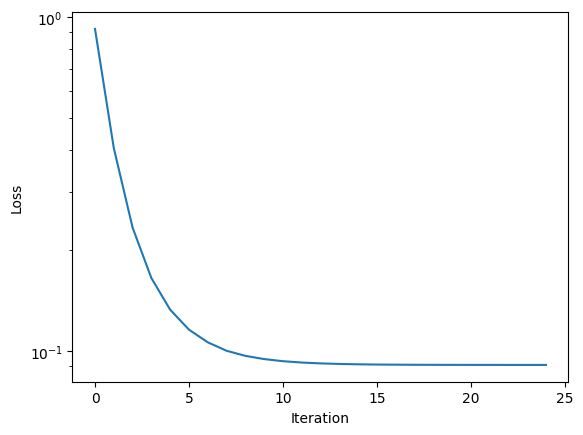

In [ ]:
print(f"Final loss: {losses[-1]:.2e}")
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.yscale('log')
plt.plot(losses);

In [ ]:
# plt.ylabel('Learning rate')
# plt.xlabel('Iteration')
# plt.plot(lr_vals);

In [ ]:
with th.no_grad():
    factors_unstacked = unstack(factors, N=N, M=M).to('cpu')
    pred_povm_full = th.matmul(factors_unstacked.conj().transpose(-1, -2), factors_unstacked)

    print(f"|| I - ΣAi†Ai ||2: {th.linalg.norm(th.eye(N) - sum(pred_povm_full), ord=2).item()}")
    print(f'Is predicted POVM valid? {"Yes" if check_povm(pred_povm_full) else "No"}')

    Fs = [ povm_fidelity(pred_povm_full[i], true_povm[i]) for i in range(M) ]
    print("Fidelities: ", Fs)
    print(f"Mean fidelity is {sum(Fs)/len(Fs)}")

|| I - ΣAi†Ai ||2: 2.0865495303955807e-15
Is predicted POVM valid? Yes
Fidelities:  [0.7606210661909006, 0.7962350636570655, 0.812354961822311]
Mean fidelity is 0.789737030556759


In [ ]:
# plot_matrix(
#     targets.cpu().numpy()[:5],
#     title="Target Probability Matrix",
#     cmap="viridis",
#     show_values= not False,
#     xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
#     ylabel=r"$|\alpha_i\rangle$",
#     colorbar=True,
#     figsize=(6, 5),
#     vmin=None,
#     vmax=None
# )

# plot_matrix(
#     pred_probs.cpu().numpy()[:5],
#     title="Predicted Probability Matrix",
#     cmap="viridis",
#     show_values= not False,
#     xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
#     ylabel=r"$|\alpha_i\rangle$",
#     colorbar=True,
#     figsize=(6, 5),
#     vmin=None,
#     vmax=None
# )